<a href="https://colab.research.google.com/github/kkzkwtr/GCI_2025_summer_competition01/blob/main/GCI_competition01_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/"

df = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

#全結合データ
df_concat = pd.concat([df,df_test],ignore_index=True)

In [ ]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類です。
テストデータのデータ数は418、変数は11種類です


In [ ]:
print(df_concat[:891].shape, df_concat[891:].shape)

(891, 12) (418, 12)


In [ ]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Perished     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Perished     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###欠損値は'Age','Cabin','Embarked'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#AgeをPclass, Sex, Parch, SibSpでランダムフォレストで推定

# 参照: https://qiita.com/jun40vn/items/d8a1f71fae680589e05c

#説明変数
age_df_concat = df_concat[["Age", "Pclass", "Sex", "Parch", "SibSp"]]

age_df_concat.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

#学習データ->欠損してないデータ、テストデータ->欠損データ
known_age = age_df_concat[age_df_concat.Age.notnull()].values
unknown_age = age_df_concat[age_df_concat.Age.isnull()].values

X = known_age[:, 1:]
y = known_age[:, 0]

# ランダムフォレスト年齢推定モデル
rf_age = RandomForestRegressor(n_estimators=100,random_state=42, n_jobs=-1)
rf_age.fit(X, y)

predictedAges = rf_age.predict(unknown_age[:, 1:])
df_concat.loc[ (df_concat.Age.isnull()), 'Age' ] = predictedAges

In [ ]:
df_concat.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,1


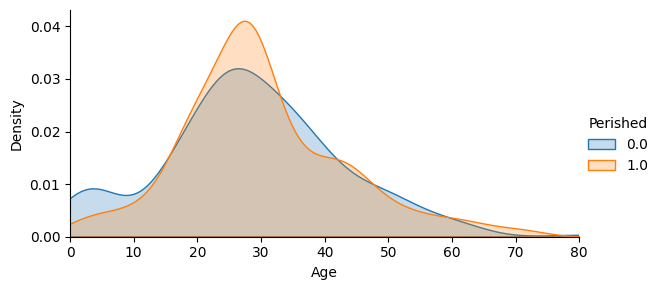

In [ ]:
#年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df_concat[:891], hue='Perished',aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df_concat[:891]['Age'].max()))
facet.add_legend()
plt.show()

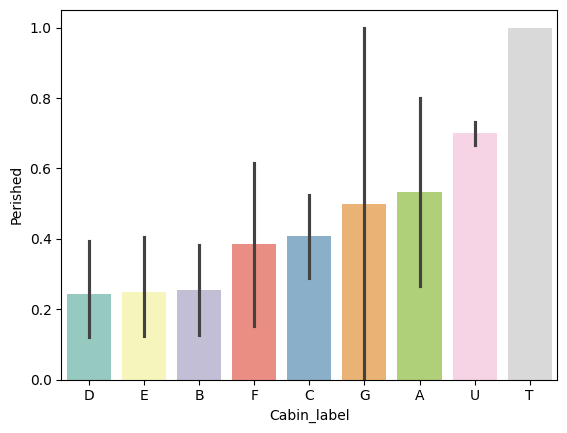

In [ ]:
#Cabinの欠損値
df_concat['Cabin'] = df_concat['Cabin'].fillna('Unknown')
df_concat['Cabin_label'] = df_concat['Cabin'].str.get(0)
mean_perished = df_concat.groupby('Cabin_label')['Perished'].mean()
order = mean_perished.sort_values(ascending=True).index.tolist()
sns.barplot(x='Cabin_label', y='Perished', data=df_concat,order=order, palette='Set3')
plt.show()

In [ ]:
# Cabin_labelのグルーピング(次元削減)
df_concat.loc[(df_concat['Cabin_label'] == 'T') | (df_concat['Cabin_label'] == 'U') | (df_concat['Cabin_label'] == 'A'), 'Cabin_label'] = 2
df_concat.loc[(df_concat['Cabin_label'] == 'G') | (df_concat['Cabin_label'] == 'C') | (df_concat['Cabin_label'] == 'F'), 'Cabin_label'] = 1
df_concat.loc[(df_concat['Cabin_label'] == 'B') | (df_concat['Cabin_label'] == 'D') | (df_concat['Cabin_label'] == 'E'), 'Cabin_label'] = 0
df_concat.drop(['Cabin'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Perished     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  Cabin_label  1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Perished     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  Cabin_label  1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


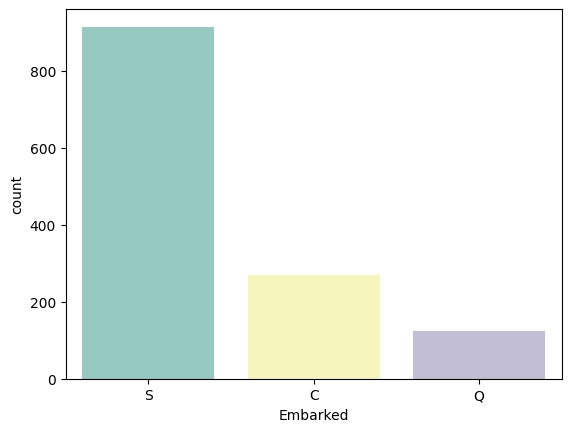

In [ ]:
#Embarkedの分布
sns.countplot(x='Embarked', data=df_concat, palette='Set3')
plt.show()

In [ ]:
df_concat['Embarked'].fillna('S', inplace=True)

df_concat.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,1


In [ ]:
#EmbarkedとPclassとの関係から(Embarked=S、Pclass=3)のFareのメジアン
fare = df_concat[(df_concat['Embarked'] == 'S')&(df_concat['Pclass'] == 3) ]['Fare'].median()
df_concat['Fare'].fillna(fare, inplace=True)
df_concat.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Perished     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Cabin_label  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [ ]:
#Sexはone-hot化
# df_concat.replace({'Sex': {'male': 0, 'female': 1}},inplace=True)
sex = df_concat['Sex']
sex_ohe = pd.get_dummies(sex,prefix='Sex')
df_concat = pd.concat([df_concat, sex_ohe], axis=1)
df_concat.drop(['Sex'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Perished     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        1309 non-null   object 
 10  Embarked     1309 non-null   object 
 11  Cabin_label  1309 non-null   object 
 12  Sex_female   1309 non-null   bool   
 13  Sex_male     1309 non-null   bool   
dtypes: bool(2), float64(3), int64(4), object(5)
memory usage: 125.4+ KB


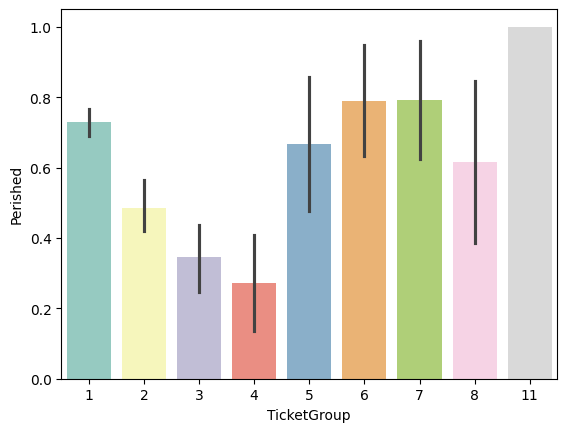

In [ ]:
#Ticket統計
Ticket_counts = dict(df_concat['Ticket'].value_counts())
df_concat['TicketGroup'] = df_concat['Ticket'].map(Ticket_counts)
sns.barplot(x='TicketGroup', y='Perished', data=df_concat, palette='Set3')
# sns.countplot(x='TicketGroup', data=df, palette='Set3')
plt.show()

# チケット番号のプレフィックスを抽出
# df['is_Ticket_Prefix'] = df['Ticket'].str.contains(r'[a-zA-Z]')
# # df_concat['is_Ticket_Prefix'] = df_concat['Ticket'].str.contains(r'[a-zA-Z]')
# sns.barplot(x='is_Ticket_Prefix', y='Perished', data=df, palette='Set3')
# plt.show()

In [ ]:
# Ticketのグルーピング
df_concat.loc[(df_concat['TicketGroup'] >= 2) & (df_concat['TicketGroup'] <= 4), 'Ticket_label'] = 2
df_concat.loc[(df_concat['TicketGroup'] >= 5) & (df_concat['TicketGroup'] <= 8) | (df_concat['TicketGroup']==1), 'Ticket_label'] = 1
df_concat.loc[(df_concat['TicketGroup'] >=11), 'Ticket_label'] = 0
df_concat.drop(['TicketGroup','Ticket'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Perished      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Name          1309 non-null   object 
 4   Age           1309 non-null   float64
 5   SibSp         1309 non-null   int64  
 6   Parch         1309 non-null   int64  
 7   Fare          1309 non-null   float64
 8   Cabin         1309 non-null   object 
 9   Embarked      1309 non-null   object 
 10  Cabin_label   1309 non-null   object 
 11  Sex_female    1309 non-null   bool   
 12  Sex_male      1309 non-null   bool   
 13  Ticket_label  1309 non-null   float64
dtypes: bool(2), float64(4), int64(4), object(4)
memory usage: 125.4+ KB


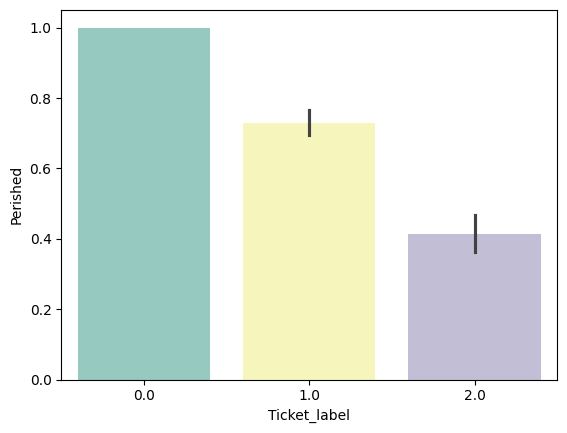

In [ ]:
sns.barplot(x='Ticket_label', y='Perished', data=df_concat, palette='Set3')
plt.show()

In [ ]:
df_concat.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Name,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0


In [ ]:
#Nameの特徴量エンジニアリング
df_concat['Title'] = df_concat['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
df_concat['Title'].value_counts()

,count
Title,
Mr,757
Miss,260
Mrs,197
Master,61
Rev,8
Dr,8
Col,4
Major,2
Mlle,2


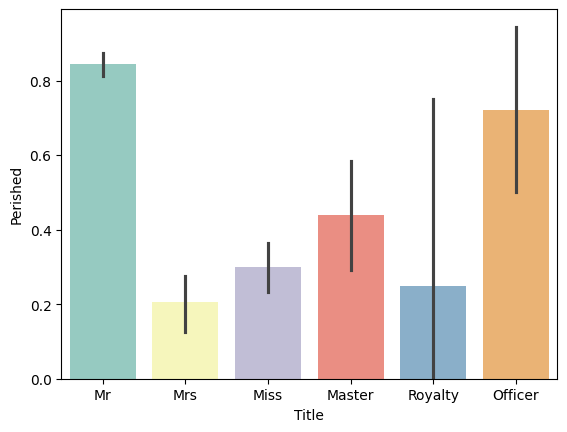

In [ ]:
df_concat['Title'].replace(['Rev','Dr', 'Col', 'Major', 'Capt'], 'Officer', inplace=True)
df_concat['Title'].replace(['Don', 'Sir', 'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df_concat['Title'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs', inplace=True)
df_concat['Title'].replace(['Mlle', 'Miss'], 'Miss', inplace=True)
df_concat['Title'].replace(['Mr'], 'Mr', inplace=True)
df_concat['Title'].replace(['Jonkheer'],'Master', inplace=True)
sns.barplot(x='Title', y='Perished', data=df_concat[:891], palette='Set3')
plt.show()

In [ ]:
#Name,Ticketは使わない
df_concat.drop(['Name'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Perished      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Age           1309 non-null   float64
 4   SibSp         1309 non-null   int64  
 5   Parch         1309 non-null   int64  
 6   Fare          1309 non-null   float64
 7   Cabin         1309 non-null   object 
 8   Embarked      1309 non-null   object 
 9   Cabin_label   1309 non-null   object 
 10  Sex_female    1309 non-null   bool   
 11  Sex_male      1309 non-null   bool   
 12  Ticket_label  1309 non-null   float64
 13  Title         1309 non-null   object 
dtypes: bool(2), float64(4), int64(4), object(4)
memory usage: 125.4+ KB


In [ ]:
#embarkedのone-hot化
emberked = df_concat['Embarked']
emberked_ohe = pd.get_dummies(emberked,prefix='Embarked')
df_concat = pd.concat([df_concat, emberked_ohe], axis=1)
df_concat.drop(['Embarked'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Perished      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Age           1309 non-null   float64
 4   SibSp         1309 non-null   int64  
 5   Parch         1309 non-null   int64  
 6   Fare          1309 non-null   float64
 7   Cabin         1309 non-null   object 
 8   Cabin_label   1309 non-null   object 
 9   Sex_female    1309 non-null   bool   
 10  Sex_male      1309 non-null   bool   
 11  Ticket_label  1309 non-null   float64
 12  Title         1309 non-null   object 
 13  Embarked_C    1309 non-null   bool   
 14  Embarked_Q    1309 non-null   bool   
 15  Embarked_S    1309 non-null   bool   
dtypes: bool(5), float64(4), int64(4), object(3)
memory usage: 119.0+ KB


In [ ]:
cabin_label = df_concat['Cabin_label']
cabin_ohe = pd.get_dummies(cabin_label,prefix='Cabin')
df_concat = pd.concat([df_concat, cabin_ohe], axis=1)
df_concat.drop(['Cabin'], axis=1, inplace=True)
df_concat.drop(['Cabin_label'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Perished      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Age           1309 non-null   float64
 4   SibSp         1309 non-null   int64  
 5   Parch         1309 non-null   int64  
 6   Fare          1309 non-null   float64
 7   Sex_female    1309 non-null   bool   
 8   Sex_male      1309 non-null   bool   
 9   Ticket_label  1309 non-null   float64
 10  Title         1309 non-null   object 
 11  Embarked_C    1309 non-null   bool   
 12  Embarked_Q    1309 non-null   bool   
 13  Embarked_S    1309 non-null   bool   
 14  Cabin_A       1309 non-null   bool   
 15  Cabin_B       1309 non-null   bool   
 16  Cabin_C       1309 non-null   bool   
 17  Cabin_D       1309 non-null   bool   
 18  Cabin_E       1309 non-null 

In [ ]:
#Family変数の追加 + グルーピング
#https://qiita.com/jun40vn/items/d8a1f71fae680589e05c
df_concat['Family'] = df_concat['SibSp'] + df_concat['Parch'] + 1
df_concat.loc[(df_concat['Family'] >= 2) & (df_concat['Family'] <= 4), 'Family_label'] = 2
df_concat.loc[(df_concat['Family'] >= 5) & (df_concat['Family'] <= 7) | (df_concat['Family']==1), 'Family_label'] = 1
df_concat.loc[(df_concat['Family'] >= 8), 'Family_label'] = 0
df_concat.drop(['Family','SibSp','Parch'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Perished      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Age           1309 non-null   float64
 4   Fare          1309 non-null   float64
 5   Sex_female    1309 non-null   bool   
 6   Sex_male      1309 non-null   bool   
 7   Ticket_label  1309 non-null   float64
 8   Title         1309 non-null   object 
 9   Embarked_C    1309 non-null   bool   
 10  Embarked_Q    1309 non-null   bool   
 11  Embarked_S    1309 non-null   bool   
 12  Cabin_A       1309 non-null   bool   
 13  Cabin_B       1309 non-null   bool   
 14  Cabin_C       1309 non-null   bool   
 15  Cabin_D       1309 non-null   bool   
 16  Cabin_E       1309 non-null   bool   
 17  Cabin_F       1309 non-null   bool   
 18  Cabin_G       1309 non-null 

In [ ]:
Title = df_concat['Title']
Title_ohe = pd.get_dummies(Title,prefix='Title')
df_concat = pd.concat([df_concat, Title_ohe], axis=1)
df_concat.drop(['Title'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Perished       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Age            1309 non-null   float64
 4   Fare           1309 non-null   float64
 5   Sex_female     1309 non-null   bool   
 6   Sex_male       1309 non-null   bool   
 7   Ticket_label   1309 non-null   float64
 8   Embarked_C     1309 non-null   bool   
 9   Embarked_Q     1309 non-null   bool   
 10  Embarked_S     1309 non-null   bool   
 11  Cabin_A        1309 non-null   bool   
 12  Cabin_B        1309 non-null   bool   
 13  Cabin_C        1309 non-null   bool   
 14  Cabin_D        1309 non-null   bool   
 15  Cabin_E        1309 non-null   bool   
 16  Cabin_F        1309 non-null   bool   
 17  Cabin_G        1309 non-null   bool   
 18  Cabin_T 

In [ ]:
df = df_concat[:891]
df_test = df_concat[891:]
df_test.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Age,0
Fare,0
Sex_female,0
Sex_male,0
Ticket_label,0
Embarked_C,0
Embarked_Q,0


In [ ]:
X = df.drop(['PassengerId', 'Perished'], axis=1).values
y = df['Perished'].values
X_test = df_test.drop(['PassengerId', 'Perished'], axis=1).values

In [ ]:
X.shape, y.shape, X_test.shape

((891, 20), (891,), (418, 20))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

[LightGBM] [Info] Number of positive: 495, number of negative: 306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617978 -> initscore=0.480973
[LightGBM] [Info] Start training from score 0.480973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

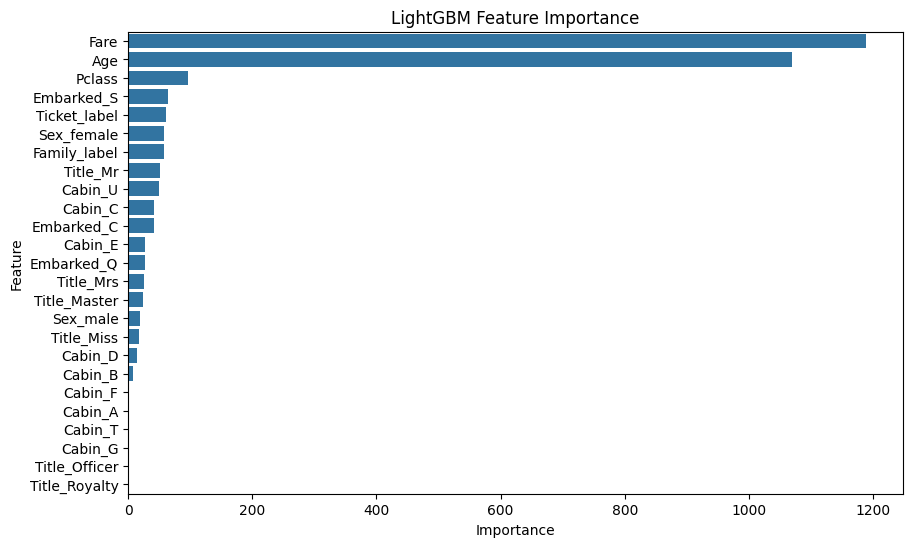

In [ ]:
# prompt: LightGBMでの特徴重要度の算出と横棒グラフでの可視化を行ってください

import pandas as pd
import matplotlib.pyplot as plt
!pip install lightgbm
import lightgbm as lgb

# LightGBMモデルの学習
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)

# 特徴量重要度の算出
importance = lgb_clf.feature_importances_
feature_names = df.drop(['PassengerId', 'Perished'], axis=1).columns

# DataFrameに変換して可視化
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None,3, 5],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [3, 10]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X, y)

print("Best parameters: ", grid_rf.best_params_)
print('CV Score: ', grid_rf.best_score_)

Best parameters:  {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
CV Score:  0.8316489862532169


In [ ]:
rf = RandomForestClassifier(
    max_depth=None,n_estimators=100,min_samples_leaf=3,min_samples_split=2,
    random_state=42, n_jobs=-1
)

# 特徴量を20個に絞る
# from sklearn.feature_selection import SelectKBest
# from sklearn.pipeline import make_pipeline
# select = SelectKBest(k = 20)

# pipe = make_pipeline(select, rf)
# pipe.fit(X_train, y_train)
rf.fit(X_train, y_train)
print('Train Score: ', rf.score(X_train, y_train))
print('Valid Score: ', rf.score(X_valid, y_valid))

Train Score:  0.8826466916354557
Valid Score:  0.8111111111111111


In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
print('Train Score: ', lr.score(X_train, y_train))
print('Valid Score: ', lr.score(X_valid, y_valid))

Train Score:  0.818976279650437
Valid Score:  0.8222222222222222


In [ ]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 100 ,10),random_state=42)
mlpc.fit(X_train, y_train)
print('Train Score: ', mlpc.score(X_train, y_train))
print('Valid Score: ', mlpc.score(X_valid, y_valid))

Train Score:  0.6779026217228464
Valid Score:  0.7111111111111111


In [ ]:
#XGBoost
import xgboost as xgb

xgb_find = xgb.XGBClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10]
}

grid_xgb = GridSearchCV(xgb_find, param_grid, cv=5, scoring='accuracy')
grid_xgb.fit(X, y)

print("Best parameters: ", grid_xgb.best_params_)
print('CV Score: ', grid_xgb.best_score_)


Best parameters:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV Score:  0.8439771514656957


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    max_depth=3,n_estimators=100,min_samples_leaf=1,min_samples_split=2,
    random_state=42, n_job=-1,
)

xgb_model.fit(X_train, y_train)
print('Train Score: ', xgb_model.score(X_train, y_train))
print('Valid Score: ', xgb_model.score(X_valid, y_valid))

Train Score:  0.9275905118601748
Valid Score:  0.8444444444444444


In [ ]:
# GBC
from sklearn.ensemble import GradientBoostingClassifier

gbc_find = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 3],
    'learning_rate': [0.01, 0.1],
    'validation_fraction': [0.1, 0.2]
}

grid_gbc = GridSearchCV(gbc_find, param_grid, cv=5, scoring='accuracy')
grid_gbc.fit(X, y)

print("Best parameters: ", grid_gbc.best_params_)
print('CV Score: ', grid_gbc.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100, 'validation_fraction': 0.1}
CV Score:  0.8350134957002071


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    max_depth=3,n_estimators=100,min_samples_leaf=3,min_samples_split=2,learning_rate=0.1,
    validation_fraction=0.1,
    random_state=42,
)

gbc.fit(X_train, y_train)
print('Train Score: ', gbc.score(X_train, y_train))
print('Valid Score: ', gbc.score(X_valid, y_valid))

Train Score:  0.9026217228464419
Valid Score:  0.8222222222222222


In [ ]:
#SVC
from sklearn.svm import SVC
svc = SVC(kernel= 'rbf',C=1.0, gamma='scale',probability=True,random_state=42)
svc.fit(X_train, y_train)
print('Train Score: ', svc.score(X_train, y_train))
print('Valid Score: ', svc.score(X_valid, y_valid))

Train Score:  0.6803995006242197
Valid Score:  0.6888888888888889


In [ ]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[
        ('rfc', rf),
        ('gbc', gbc),
        ('lr', lr),
        ('xgb', xgb_model),
    ],
    voting='soft',
)

voting.fit(X_train, y_train)
print('Train Score: ', voting.score(X_train, y_train))
print('Valid Score: ', voting.score(X_valid, y_valid))

Train Score:  0.898876404494382
Valid Score:  0.8333333333333334


In [ ]:
#スタッキング
from sklearn.ensemble import StackingClassifier

stacking = StackingClassifier(
    estimators=[
        ('rfc', rf),
        ('gbc', gbc),
        ('lr', lr),
        ('xgb',xgb_model)
    ],
    final_estimator=LogisticRegression(random_state=42),
)

stacking.fit(X_train, y_train)
print('Train Score: ', stacking.score(X_train, y_train))
print('Valid Score: ', stacking.score(X_valid, y_valid))

Train Score:  0.9001248439450686
Valid Score:  0.8444444444444444


In [ ]:
#VotingClassifierのスコア保存
voting_pred = voting.predict_proba(X_test)
pred = voting_pred.argmax(axis=1)

In [ ]:
stacking_pred = stacking.predict_proba(X_test)
pred = stacking_pred.argmax(axis=1)

In [ ]:
#selectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline

select = SelectKBest(k = 20)

pipe = make_pipeline(select, rf)
pipe.fit(X_train, y_train)
rfc_pred = pipe.predict_proba(X_test)
pred = rfc_pred.argmax(axis=1)

In [ ]:
df.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Age', 'Fare', 'Sex_female',
       'Sex_male', 'Ticket_label', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'Family_label', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty'],
      dtype='object')

In [ ]:
mask = select.get_support()
list_col = list(df.columns[2:])
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=', mask[i])
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

No1 Pclass = True
No2 Age = True
No3 Fare = True
No4 Sex_female = True
No5 Sex_male = True
No6 Ticket_label = True
No7 Embarked_C = True
No8 Embarked_Q = False
No9 Embarked_S = True
No10 Cabin_A = False
No11 Cabin_B = True
No12 Cabin_C = True
No13 Cabin_D = True
No14 Cabin_E = True
No15 Cabin_F = True
No16 Cabin_G = False
No17 Cabin_T = False
No18 Cabin_U = True
No19 Family_label = True
No20 Title_Master = True
No21 Title_Miss = True
No22 Title_Mr = True
No23 Title_Mrs = True
No24 Title_Officer = False
No25 Title_Royalty = True
X.shape=(891, 25), X_selected.shape=(891, 20)


In [ ]:
#ランダムフォレスト単独のcsv
rfc_pred = rf.predict_proba(X_test)
pred = rfc_pred.argmax(axis=1)

In [ ]:
rfc_pred = rf.predict_proba(X_test)
lr_pred = lr.predict_proba(X_test)
mlpc_pred = mlpc.predict_proba(X_test)

pred_proba = (rfc_pred + lr_pred + mlpc_pred) / 3
pred = pred_proba.argmax(axis=1)

ValueError: X has 25 features, but RandomForestClassifier is expecting 20 features as input.

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/'

submission = pd.read_csv(path + 'gender_submission.csv')
submission

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [ ]:
pred.shape

(418,)

In [ ]:
submission['Perished'] = pred
submission

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [ ]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あり
submission.to_csv('/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/submission_v10.csv', index=False)

In [ ]:
test_augumented = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/data/test_augmented.csv')
test_augumented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Survived     418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [ ]:
# prompt: test_augumentedのSurvivedカラムをPerishedに変え、0,1を反転してください
test_augumented = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/data/test_augmented.csv')
test_augumented.rename(columns={'Survived': 'Perished'}, inplace=True)
test_augumented['Perished'] = 1 - test_augumented['Perished']

In [ ]:
#正解スコアを見る
from sklearn.metrics import accuracy_score
accuracy_score(submission['Perished'], test_augumented['Perished'])

0.7679425837320574

In [ ]:
# prompt: google drive上にsubmission_v{数字}.csvという形で保存しているすべてのcsvのperishedとのaccuracy_scoreを並べるコードを書いて

import pandas as pd
import os

# Google Drive上のsubmissionファイルのパス
submission_dir = '/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/'

# テストデータの正解ラベルファイル
test_augmented_path = '/content/drive/MyDrive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/data/test_augmented.csv'
test_augmented = pd.read_csv(test_augmented_path)
test_augmented.rename(columns={'Survived': 'Perished'}, inplace=True)
test_augmented['Perished'] = 1 - test_augmented['Perished'] # 正解ラベルをPerishedに合わせる

# submission_v{数字}.csv ファイルを検索し、accuracy_scoreを計算
accuracy_scores = {}
for file in os.listdir(submission_dir):
    if file.startswith('submission_v') and file.endswith('.csv'):
        try:
            submission_path = os.path.join(submission_dir, file)
            submission_df = pd.read_csv(submission_path)

            # submissionファイルとtest_augmentedファイルのPassengerIdが一致しているか確認
            if submission_df['PassengerId'].equals(test_augmented['PassengerId']):
                accuracy = accuracy_score(test_augmented['Perished'], submission_df['Perished'])
                accuracy_scores[file] = accuracy
            else:
                print(f"Warning: PassengerId mismatch between {file} and test_augmented.csv. Skipping.")

        except Exception as e:
            print(f"Error processing {file}: {e}")

# accuracy_scoreをファイル名と一緒に表示
print("Accuracy scores for submission files:")
for file, score in sorted(accuracy_scores.items()): # ファイル名でソートして表示
    print(f"{file}: {score:.4f}")


Accuracy scores for submission files:
submission_v10.csv: 0.7679
submission_v2.csv: 0.7608
submission_v3.csv: 0.7608
submission_v4.csv: 0.7799
submission_v5.csv: 0.7823
submission_v6.csv: 0.7751
submission_v7.csv: 0.7679
submission_v8.csv: 0.7679
submission_v9.csv: 0.7847
